In [2]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

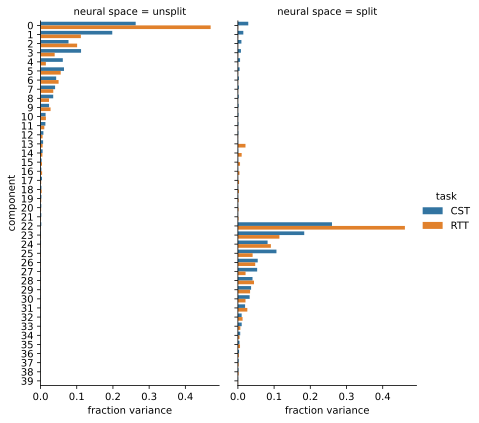

In [3]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

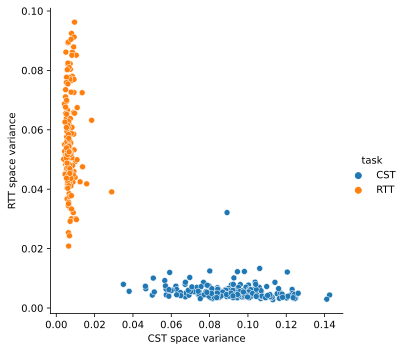

In [4]:
src.plot.plot_single_trial_split_var(td,signal='lfads_rates_joint_pca')

In [12]:
import plotly.express as px

signal = 'lfads_rates_joint_pca_shared'
df = src.decoder_analysis.precondition_td(td, signal)
models = src.decoder_analysis.fit_models(df, signal, target_name='Hand velocity')

trial_scores = src.decoder_analysis.score_trials(df.loc[df['Test set']],signal,models,target_name='Hand velocity')

fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial_id'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

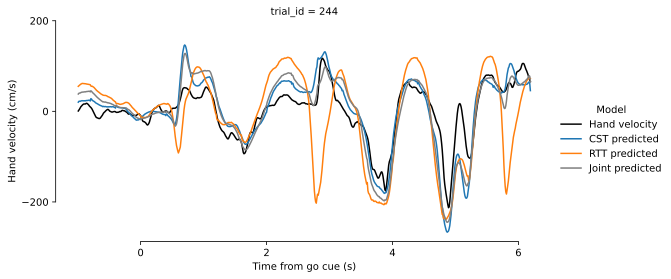

In [61]:
trials_to_plot = [244]
trial_pred = (
    df
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .reset_index()
    .melt(
        id_vars=['trial_id','Time from go cue (s)','task'],
        value_vars=['Hand velocity','CST predicted','RTT predicted','Joint predicted'],
        var_name='Model',
        value_name='Hand velocity (cm/s)',
    )
)
g=sns.relplot(
    data=trial_pred,
    x='Time from go cue (s)',
    y='Hand velocity (cm/s)',
    hue='Model',
    hue_order=['Hand velocity','CST predicted','RTT predicted','Joint predicted'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    row='trial_id',
    row_order=trials_to_plot,
    height=4,
    aspect=2,
)
g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)

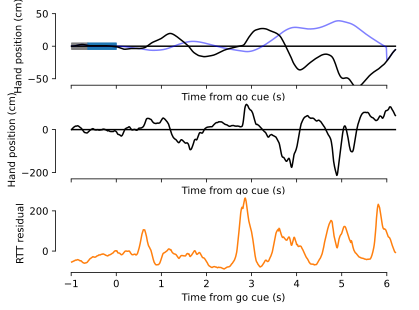

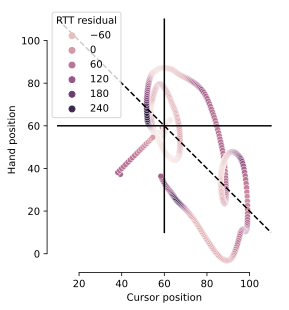

In [62]:
trials_to_plot = [244]
df_resid = (
    df
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .assign(
        **{
            f'{model} residual': lambda d,model=model: d['Hand velocity']-d[f'{model} predicted']
            for model in ['CST','RTT','Joint']
        }
    )
)
trial_resid = (
    df_resid
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .reset_index()
)

trial = td.loc[td['trial_id']==trials_to_plot[0],:].squeeze()
fig,axs = plt.subplots(3,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
sns.lineplot(
    data=trial_resid,
    x='Time from go cue (s)',
    y='RTT residual',
    ax=axs[2],
    color='C1',
)
sns.despine(fig=fig,trim=True)

sm_fig,sm_ax = plt.subplots(1,1)
sns.scatterplot(
    data=trial_resid,
    x='Cursor position',
    y='Hand position',
    hue='RTT residual',
    ax=sm_ax,
)
sm_ax.plot([60,60],[10,110],'k-')
sm_ax.plot([10,110],[60,60],'k-')
sm_ax.plot([10,110],[110,10],'k--')
sm_ax.set_aspect('equal')
sns.despine(ax=sm_ax,trim=True)